## Aim of the stakeholder and summary of the Project

My team and I worked on a project for a data-driven farming company. The company helps farmers monitor their crops by providing useful information from sensors planted in the soil. The company wanted to improve their monitoring system by utilizing a new type of data: satellite images. My team and I investigated whether using satellite images could provide additional information to the farmers. We used an American dataset that extracted visual features from satellite images of fields (parcels). Our aim was to predict the NDVI of the parcels.

NDVI stands for Normalized Difference Vegetation Index. It is a widely used remote sensing technique to analyze and monitor vegetation health and density. NDVI prediction in agriculture offers numerous advantages for farmers, society, and our stakeholder. NDVI is a proven effective indicator of vegetation distribution, growth, health, and productivity changes over space and time. A higher NDVI indicates more vegetation and is also highly correlated with crop yield, making NDVI prediction a valuable tool for more efficient water usage, cost savings, and improved profitability for farmers. Moreover, it plays a crucial role in the fight against climate change.

This notebook documents my contribution to the project. Specifically, I preprocessed the data and utilized linear regression to make short-term predictions based on weather features in Part 1. The main reason for experimenting with linear regression was its explainability. Additionally, my team experimented with more complex models such as random forest, XGBoost, and deep learning; and linear regression served as our baseline model. In Part 2, I also explored different forecasting models to make long-term predictions based on NDVI time series.

To clarify, the satellite images only provide data for the NDVI, which is computed using the RED and NIR bands of the image. In Part 1, the following features were used to predict the NDVI: temperature, drought index, heatwave index, precipitation, and the current NDVI of the field. In Part 2, only past values of NDVIs were used to predict future NDVI values.

## Data Preprocessing

Useful imports

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

retrieve data from the numpy files

In [2]:
# specify the directory containing the .npy files
directory = '/Users/mattiacintioli/UvA_DS/Augurotech DSP/corn'

# create an empty list to store the DataFrames
df_list = []

# iterate through the files in the directory
for file in os.listdir(directory):
    if file.endswith('.npy'):
        # load the .npy file
        data = np.load(os.path.join(directory, file))
        # extract the year and parcel id from the file name
        year = int(file[:4])
        parcel_id = int(file[5:10])
        # create a DataFrame from the data
        df = pd.DataFrame(data)
        # add the year and parcel id as new columns
        df['year'] = year
        df['parcel_id'] = parcel_id
        # append the DataFrame to the list
        df_list.append(df)

# concatenate the DataFrames together
result = pd.concat(df_list, axis=0)

In [3]:
#change name of columns
COUNTY_FEATURE_NAMES = ["RED","NIR","BLUE","GREEN","NIR2","SWIR1","SWIR2","TEMP_MIN","TEMP_MAX","PRCP","HEATWAVE INDEX","DROUGHT INDEX","NDVI","EVI","NDWI"]
result = result.rename(columns=dict(zip(result.columns[:15],COUNTY_FEATURE_NAMES)))

In [4]:
#changing indexes such that for first instance of 2003 index=0 and for last instance of 2021 index=873
years = result["year"].values
idx = result.index.values
new_idx = idx + (years-2003)*46
result = result.set_index(new_idx)
result["date"]= result.index.values

retrieve labels (crop_yield) from the labels.json file

In [5]:
import json

# load the json data
with open(directory+'/labels.json') as json_file:
    yield_data = json.load(json_file)

# convert the json data into a DataFrame
yield_df = pd.DataFrame.from_dict(yield_data, orient='index', columns=['crop_yield'])

# extract year and parcel_id from the index of the yield_df
yield_df['year'] = yield_df.index.str[-4:]
yield_df['parcel_id'] = yield_df.index.str[:-5]

#convert columns from str to int
yield_df[["year", "parcel_id"]] = yield_df[["year", "parcel_id"]].astype(int)


# merge the yield_df with the original dataframe
result = pd.merge(result, yield_df, on=['year','parcel_id'])
#result = result.set_index('date') #uncomment if you want to have the index=date

result.tail()

,RED,NIR,BLUE,GREEN,NIR2,SWIR1,SWIR2,TEMP_MIN,TEMP_MAX,PRCP,HEATWAVE INDEX,DROUGHT INDEX,NDVI,EVI,NDWI,year,parcel_id,date,crop_yield
363809,936.535706,1946.250000,467.196442,765.196411,2568.089355,2401.017822,1426.535767,-5.086429,6.541250,1.678817,0.058929,1.0,0.344371,0.596906,-0.142324,2008,18115,271,131.0
363810,1122.571411,2096.000000,648.303589,940.375000,2670.714355,2394.714355,1462.232178,-3.960067,4.974889,1.180469,0.000000,1.0,0.306267,0.521924,-0.121708,2008,18115,272,131.0
363811,1660.392822,2434.732178,1269.642822,1500.232178,2945.571533,2719.875000,1875.500000,-4.556630,5.400022,3.672567,0.000000,1.0,0.228138,0.381104,-0.104688,2008,18115,273,131.0
363812,1121.982178,2094.250000,519.053589,873.732117,2682.321533,2248.000000,1300.625000,-4.085201,6.205134,4.696406,0.000000,1.0,0.295967,0.504985,-0.120278,2008,18115,274,131.0
363813,1035.517822,1855.017822,489.053558,799.964294,2465.107178,2394.839355,1442.714233,-4.543884,10.427142,7.029710,0.000000,1.0,0.278088,0.473481,-0.133669,2008,18115,275,131.0


In [6]:
#check that crop_yield for year=2003 and parcel_id=18007 is the same as in the json file
result[(result["year"] == 2003) & (result["parcel_id"] == 18007)][["year","parcel_id","crop_yield"]].head()

,year,parcel_id,crop_yield
253598,2003,18007,164.1
253599,2003,18007,164.1
253600,2003,18007,164.1
253601,2003,18007,164.1
253602,2003,18007,164.1


In [7]:
result.describe()

,RED,NIR,BLUE,GREEN,NIR2,SWIR1,SWIR2,TEMP_MIN,TEMP_MAX,PRCP,HEATWAVE INDEX,DROUGHT INDEX,NDVI,EVI,NDWI,year,parcel_id,date,crop_yield
count,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000,363814.000000
mean,1705.336403,3296.341209,1278.509403,1592.389079,3257.529586,2577.493327,1568.586189,3.973470,15.841636,2.665989,0.052488,0.573318,0.398079,0.664266,-0.032645,2011.906056,21966.951953,432.178594,165.813921
std,2261.169402,1924.679437,2318.557914,2257.998647,1332.501628,1371.315220,1329.882971,10.700172,11.579752,3.091595,0.199286,1.030449,0.254935,69.657390,0.140541,5.375986,5511.386608,247.651475,30.177571
min,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-33.487942,-23.489592,0.000000,0.000000,0.000000,-0.148339,-42012.976562,-0.292686,2003.000000,17001.000000,0.000000,19.000000
25%,748.727249,2274.662476,391.142426,706.081985,2893.522217,2139.054932,987.276581,-3.983691,6.304401,0.422135,0.000000,0.000000,0.243926,0.400413,-0.138983,2007.000000,18023.000000,219.000000,149.600000
50%,1094.386841,2854.528564,557.348236,895.407135,3304.392334,2604.137817,1584.598206,4.394568,17.395063,1.647471,0.000000,0.000000,0.341038,0.589916,-0.084814,2012.000000,19063.000000,429.000000,169.500000
75%,1484.837372,3995.883362,771.953522,1185.569672,3661.342712,3134.059204,2126.026184,13.756459,26.360761,3.845201,0.000000,1.000000,0.588198,1.158165,0.055282,2016.000000,27115.000000,642.000000,185.900000
max,9395.751953,8988.855469,9385.594727,9447.789062,6622.949707,6430.720703,4982.773438,24.312654,39.573845,38.450455,0.990000,5.000000,1.257229,2.223948,1.347862,2021.000000,31185.000000,873.000000,246.700000


In [8]:
#there are 466 different parcels
result["parcel_id"].unique().size

466

In [9]:
#no missing values
result.isna().sum()

RED               0
NIR               0
BLUE              0
GREEN             0
NIR2              0
SWIR1             0
SWIR2             0
TEMP_MIN          0
TEMP_MAX          0
PRCP              0
HEATWAVE INDEX    0
DROUGHT INDEX     0
NDVI              0
EVI               0
NDWI              0
year              0
parcel_id         0
date              0
crop_yield        0
dtype: int64

Let's look at the distributions

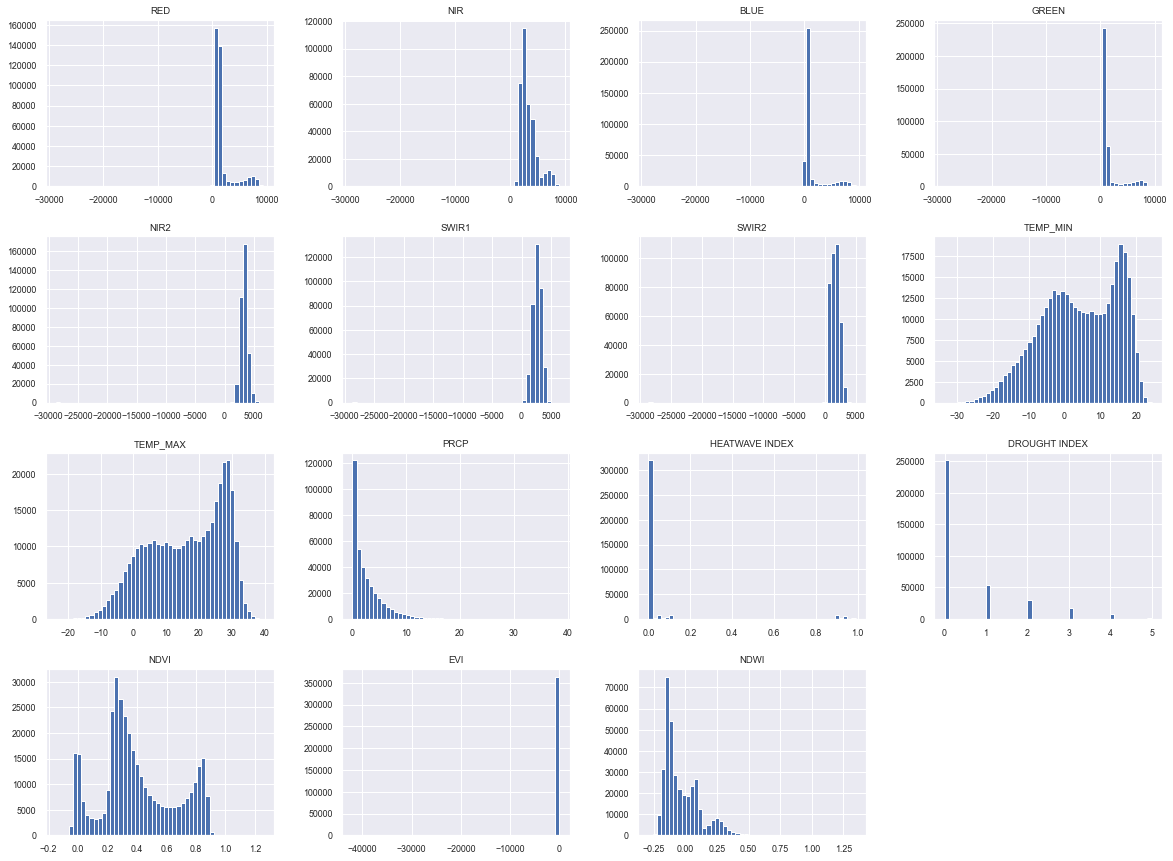

In [508]:
#distributions of independent variables (features)

# plot histograms of the first 15 columns
result.iloc[:, :15].hist(bins=50, figsize=(20, 15))

# show the plot
plt.show()

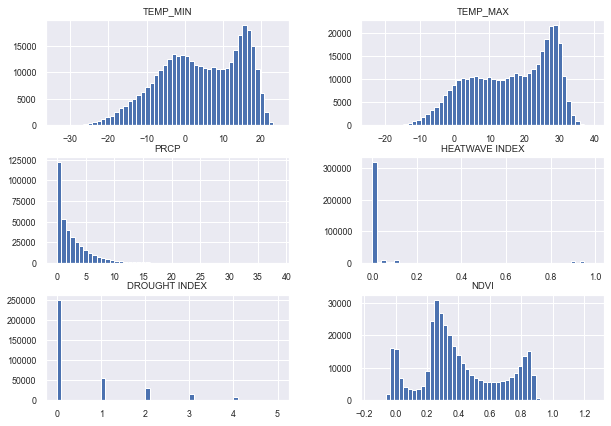

In [509]:
#distributions of independent variables (features)
sns.set_theme(font_scale=0.8)

# plot histograms of the first 15 columns
result.loc[:, ['TEMP_MIN','TEMP_MAX','PRCP','HEATWAVE INDEX','DROUGHT INDEX','NDVI'] ].hist(bins=50, figsize=(10, 7), color = "b")

# show the plot
plt.show()

Since distributions of features don't look normal we will use MinMaxScaler instead of StandardScaler to scale the data

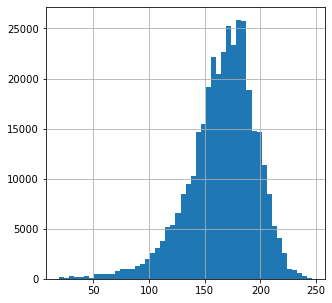

In [11]:
#distribution of target variable

# plot histograms of the first 15 columns
result.loc[:, "crop_yield"].hist(bins=50, figsize=(5, 5))

# show the plot
plt.show()

We won't scale target variable since it is usually not recommended

### Parcels

In [22]:
#following function extracts parcel based on parcel id
def extract_parcel(parcel_id):
    #get parcel
    parcel_df = result[result["parcel_id"]==parcel_id].sort_index()
    
    #scale the data
    scaler = MinMaxScaler()
    features = ["RED","NIR","BLUE","GREEN","NIR2","SWIR1","SWIR2","TEMP_MIN","TEMP_MAX",
                "PRCP","HEATWAVE INDEX","NDVI","EVI","NDWI"] #no drought index since it is categorical
    scaler.fit(parcel_df.loc[:, features])
    parcel_df.loc[:, features] = scaler.transform(parcel_df.loc[:, features])
    
    #one-hot encoding Drought Index
    parcel_df = pd.get_dummies(parcel_df, columns=['DROUGHT INDEX'])
    
    #change index
    parcel_df = parcel_df.set_index('date').sort_index()
    
    #create lagged values
    parcel_df["NDVI_1lag"] = parcel_df["NDVI"].shift(+1)

    #substitute first value since it is NAN
    parcel_df.iloc[0,-1] = parcel_df.iloc[0,11]
    
    #TODO, we could also try to remove outliers, for now let's try without
    
    return parcel_df
    
parcel = extract_parcel(17193)
parcel

,RED,NIR,BLUE,GREEN,NIR2,SWIR1,SWIR2,TEMP_MIN,TEMP_MAX,PRCP,...,year,parcel_id,crop_yield,DROUGHT INDEX_0.0,DROUGHT INDEX_1.0,DROUGHT INDEX_2.0,DROUGHT INDEX_3.0,DROUGHT INDEX_4.0,DROUGHT INDEX_5.0,NDVI_1lag
date,,,,,,,,,,,,,,,,,,,,,
0,0.801939,0.831076,0.791357,0.800599,0.893895,0.923320,0.929474,0.425207,0.232346,0.230751,...,2003,17193,120.0,1,0,0,0,0,0,0.435622
1,0.805296,0.835452,0.792299,0.802065,0.904058,0.943472,0.952682,0.328877,0.266375,0.000000,...,2003,17193,120.0,1,0,0,0,0,0,0.435622
2,0.836745,0.861963,0.822693,0.832992,0.915909,0.935822,0.945388,0.192245,0.162129,0.000650,...,2003,17193,120.0,1,0,0,0,0,0,0.415955
3,0.844179,0.869769,0.827698,0.839568,0.922312,0.938899,0.947576,0.102484,0.118891,0.010573,...,2003,17193,120.0,1,0,0,0,0,0,0.297842
4,0.804447,0.831291,0.792071,0.800768,0.900881,0.937965,0.944510,0.388476,0.317317,0.036607,...,2003,17193,120.0,1,0,0,0,0,0,0.236737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,0.807384,0.842665,0.793456,0.802925,0.910611,0.939859,0.940384,0.356077,0.364504,0.049574,...,2021,17193,193.2,1,0,0,0,0,0,0.441805
870,0.811270,0.848818,0.795308,0.806099,0.918312,0.948772,0.946845,0.447178,0.477812,0.175111,...,2021,17193,193.2,1,0,0,0,0,0,0.438430
871,0.804203,0.838237,0.791967,0.800213,0.903133,0.929884,0.932341,0.393339,0.428813,0.041731,...,2021,17193,193.2,1,0,0,0,0,0,0.423453


In [23]:
parcel.iloc[:,17:]

,DROUGHT INDEX_0.0,DROUGHT INDEX_1.0,DROUGHT INDEX_2.0,DROUGHT INDEX_3.0,DROUGHT INDEX_4.0,DROUGHT INDEX_5.0,NDVI_1lag
date,,,,,,,
0,1,0,0,0,0,0,0.435622
1,1,0,0,0,0,0,0.435622
2,1,0,0,0,0,0,0.415955
3,1,0,0,0,0,0,0.297842
4,1,0,0,0,0,0,0.236737
...,...,...,...,...,...,...,...
869,1,0,0,0,0,0,0.441805
870,1,0,0,0,0,0,0.438430
871,1,0,0,0,0,0,0.423453


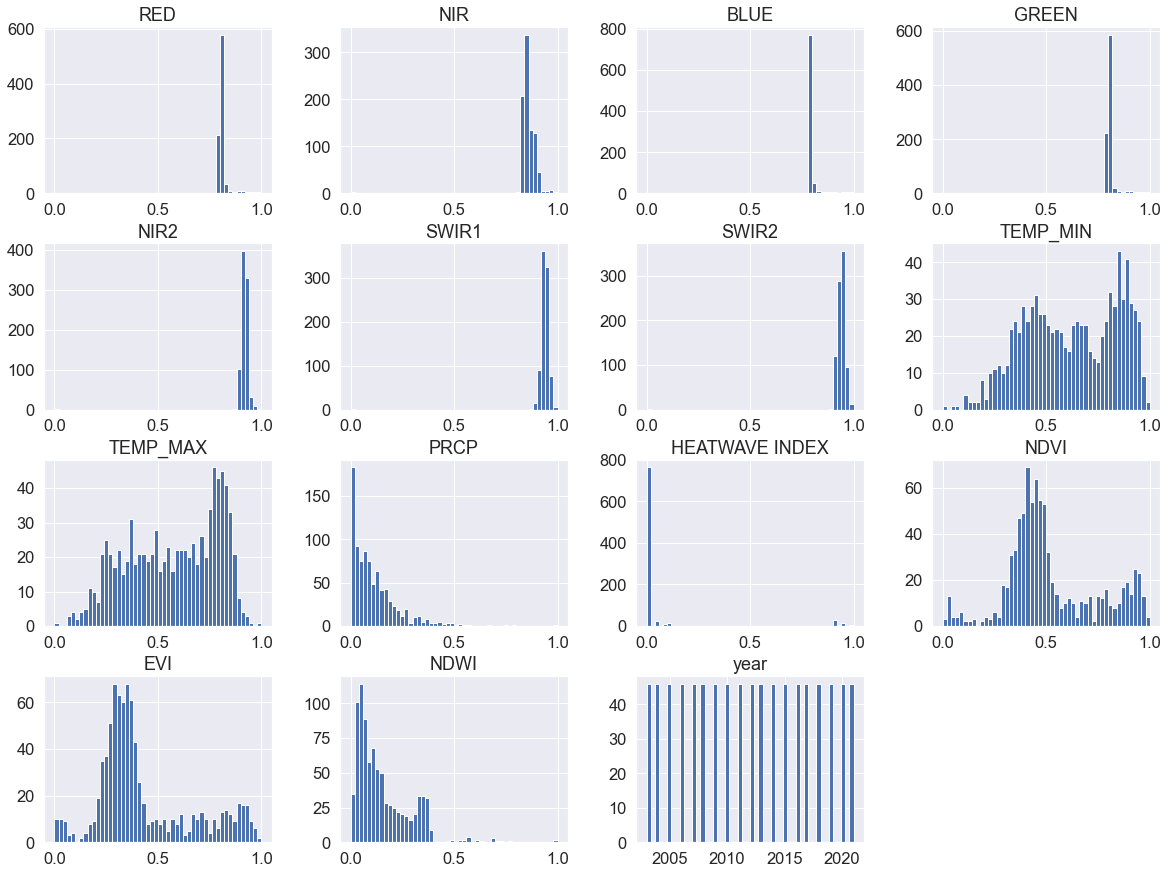

In [24]:
parcel.iloc[:, :15].hist(bins=50, figsize=(20, 15))

# show the plot
plt.show()

features' distributions look better now

In [25]:
parcel.head()

,RED,NIR,BLUE,GREEN,NIR2,SWIR1,SWIR2,TEMP_MIN,TEMP_MAX,PRCP,...,year,parcel_id,crop_yield,DROUGHT INDEX_0.0,DROUGHT INDEX_1.0,DROUGHT INDEX_2.0,DROUGHT INDEX_3.0,DROUGHT INDEX_4.0,DROUGHT INDEX_5.0,NDVI_1lag
date,,,,,,,,,,,,,,,,,,,,,
0,0.801939,0.831076,0.791357,0.800599,0.893895,0.923320,0.929474,0.425207,0.232346,0.230751,...,2003,17193,120.0,1,0,0,0,0,0,0.435622
1,0.805296,0.835452,0.792299,0.802065,0.904058,0.943472,0.952682,0.328877,0.266375,0.000000,...,2003,17193,120.0,1,0,0,0,0,0,0.435622
2,0.836745,0.861963,0.822693,0.832992,0.915909,0.935822,0.945388,0.192245,0.162129,0.000650,...,2003,17193,120.0,1,0,0,0,0,0,0.415955
3,0.844179,0.869769,0.827698,0.839568,0.922312,0.938899,0.947576,0.102484,0.118891,0.010573,...,2003,17193,120.0,1,0,0,0,0,0,0.297842
4,0.804447,0.831291,0.792071,0.800768,0.900881,0.937965,0.944510,0.388476,0.317317,0.036607,...,2003,17193,120.0,1,0,0,0,0,0,0.236737


Let's plot how crop_yield changes in time

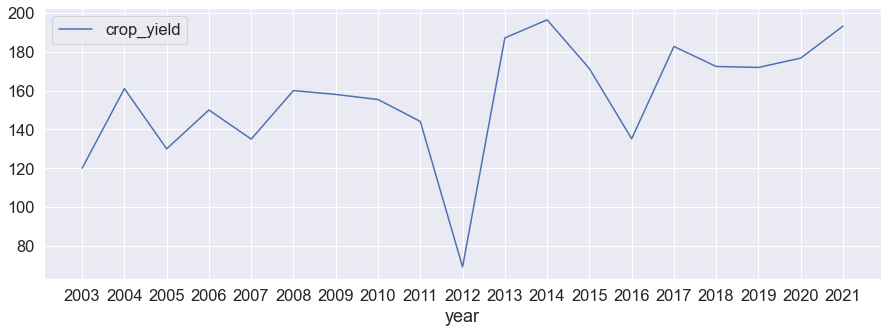

In [26]:
# Plot the data
#plt.plot(parcel.groupby("year").mean()["crop_yield"])
parcel.plot(x='year', y='crop_yield', kind='line', figsize=(15,5))

# Get the unique years 
years = parcel["year"].unique()

# Set the x-axis tick positions and labels
plt.xticks(years, years)

plt.show()

Let's plot how NDVI changes in time

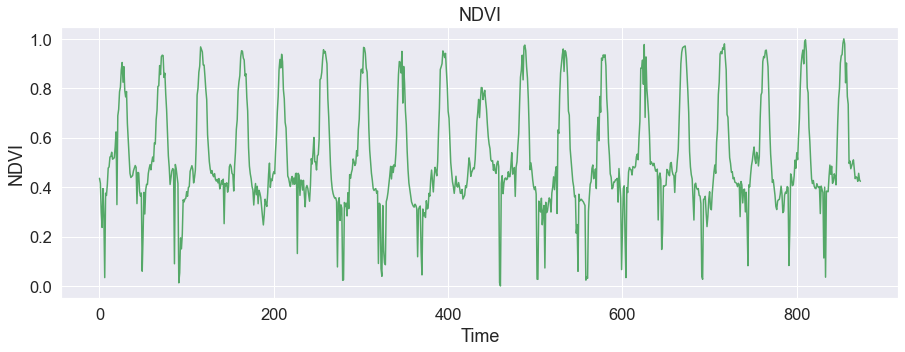

In [27]:
# Plot the data
#plt.plot(parcel.groupby("year").mean()["crop_yield"])
#parcel.plot(y='NDVI', kind='line', figsize=(15,5))
sns.set_theme(font_scale=1.5)
plt.figure(figsize=(15, 5))
plt.plot(parcel["NDVI"], color='g')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.title('NDVI')

plt.show()

Let's see if there is correlation between features

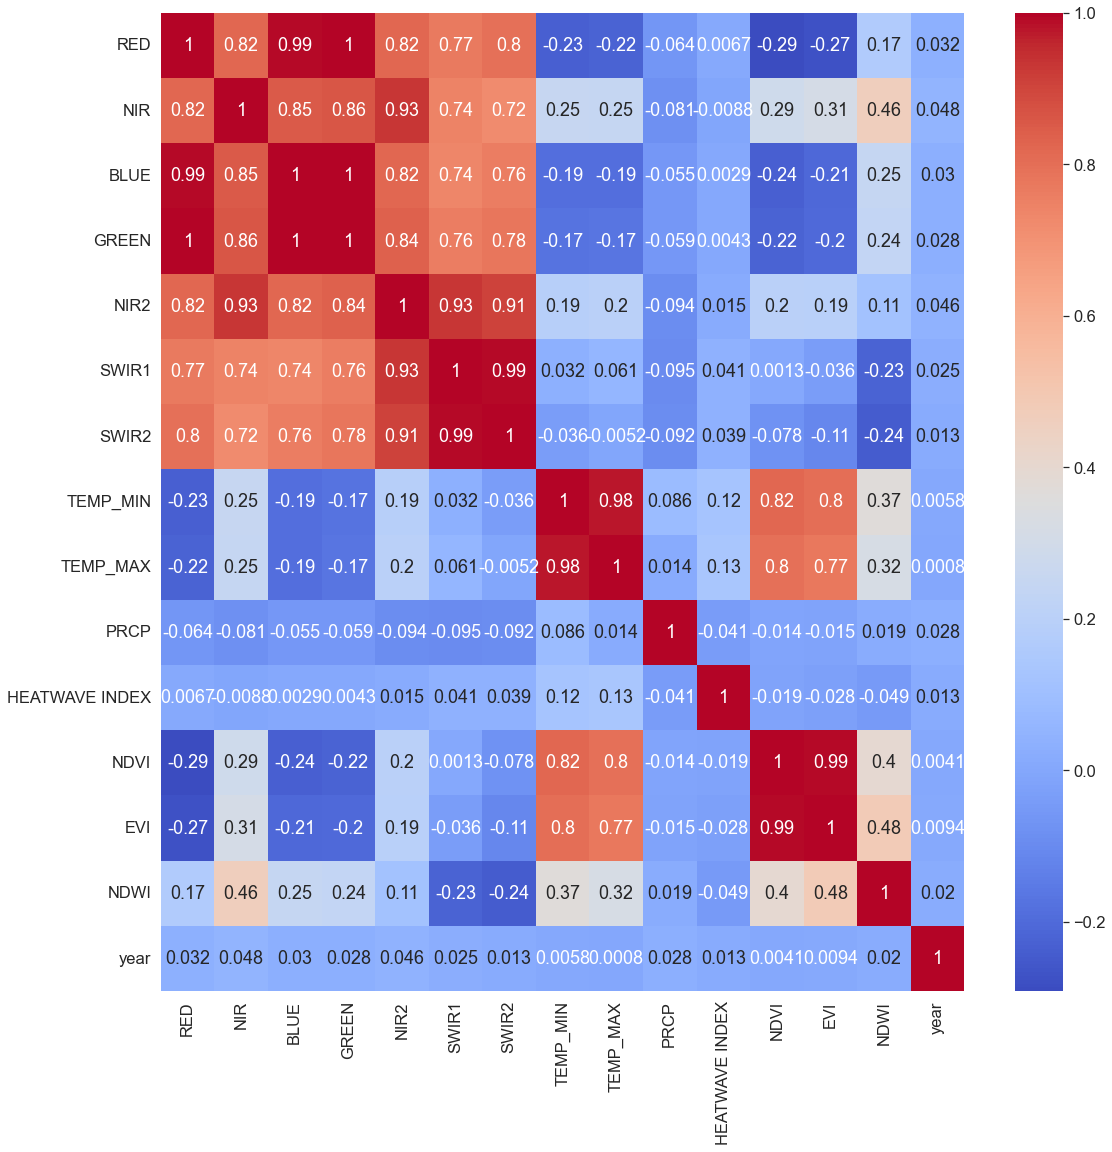

In [31]:
corr_matrix = parcel.iloc[:,:15].corr()

fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

# Show the plot
plt.show()


#corr = parcel.iloc[:,:15].corr()
#plt.figure(figsize=(12, 10))
#sns.heatmap(corr[(corr >= 0.8) | (corr <= -0.8)], 
#            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
#            annot=True, annot_kws={"size": 8}, square=True);

- RED, BLUE, GREEN are correlated
- SWIR1 and SWIR2 are correlated
- NIR and NIR2 are correlated
- TEMP_MIN and TEMP_MAX are correlated
- NDVI and EVI are correlated

So we will drop BLUE, GREEN, SWIR2, NIR2, TEMP_MAX, and EVI

In [32]:
parcel = parcel.drop(columns=["BLUE", "GREEN", "SWIR2", "NIR2", "TEMP_MAX", "EVI"])
parcel.head()

,RED,NIR,SWIR1,TEMP_MIN,PRCP,HEATWAVE INDEX,NDVI,NDWI,year,parcel_id,crop_yield,DROUGHT INDEX_0.0,DROUGHT INDEX_1.0,DROUGHT INDEX_2.0,DROUGHT INDEX_3.0,DROUGHT INDEX_4.0,DROUGHT INDEX_5.0,NDVI_1lag
date,,,,,,,,,,,,,,,,,,
0,0.801939,0.831076,0.923320,0.425207,0.230751,0.000000,0.435622,0.069716,2003,17193,120.0,1,0,0,0,0,0,0.435622
1,0.805296,0.835452,0.943472,0.328877,0.000000,0.000000,0.415955,0.030621,2003,17193,120.0,1,0,0,0,0,0,0.435622
2,0.836745,0.861963,0.935822,0.192245,0.000650,0.000000,0.297842,0.146884,2003,17193,120.0,1,0,0,0,0,0,0.415955
3,0.844179,0.869769,0.938899,0.102484,0.010573,0.100327,0.236737,0.208773,2003,17193,120.0,1,0,0,0,0,0,0.297842
4,0.804447,0.831291,0.937965,0.388476,0.036607,0.000000,0.394078,0.006486,2003,17193,120.0,1,0,0,0,0,0,0.236737


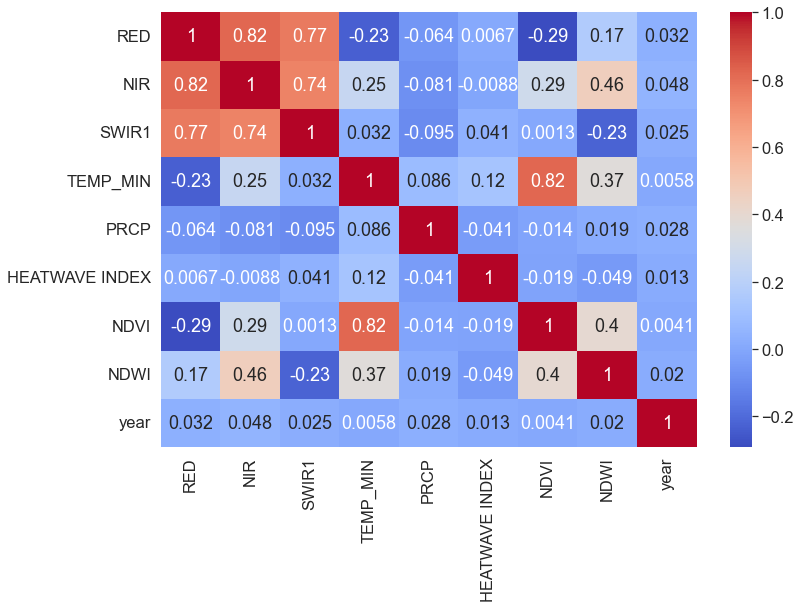

In [33]:
corr_matrix = parcel.iloc[:,:9].corr()

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

# Show the plot
plt.show()

There are no more corrleations > 0.9. We might try in a later stage to drop features for correlations over 0.8 and 0.7

In [19]:
result.to_csv('result.csv')

## Modelling Part 1: Linear Regression

There are two problems to address before modelling.
1) We have for every parcel (county) data from 2003 to 2021. Every year we have 46 images (46 data points). 46 because we have 1 image every 8 days. The problem is that the label that we are trying to predict (crop yield) is yearly. So for all the 46 datapoints of a given year we have the same output. Teng suggested to use models such as LSTM.

2) There are around 470 parcels. Do we create models for each parcel? 

In [34]:
parcel = extract_parcel(17193)
parcel.head()

,RED,NIR,BLUE,GREEN,NIR2,SWIR1,SWIR2,TEMP_MIN,TEMP_MAX,PRCP,...,year,parcel_id,crop_yield,DROUGHT INDEX_0.0,DROUGHT INDEX_1.0,DROUGHT INDEX_2.0,DROUGHT INDEX_3.0,DROUGHT INDEX_4.0,DROUGHT INDEX_5.0,NDVI_1lag
date,,,,,,,,,,,,,,,,,,,,,
0,0.801939,0.831076,0.791357,0.800599,0.893895,0.923320,0.929474,0.425207,0.232346,0.230751,...,2003,17193,120.0,1,0,0,0,0,0,0.435622
1,0.805296,0.835452,0.792299,0.802065,0.904058,0.943472,0.952682,0.328877,0.266375,0.000000,...,2003,17193,120.0,1,0,0,0,0,0,0.435622
2,0.836745,0.861963,0.822693,0.832992,0.915909,0.935822,0.945388,0.192245,0.162129,0.000650,...,2003,17193,120.0,1,0,0,0,0,0,0.415955
3,0.844179,0.869769,0.827698,0.839568,0.922312,0.938899,0.947576,0.102484,0.118891,0.010573,...,2003,17193,120.0,1,0,0,0,0,0,0.297842
4,0.804447,0.831291,0.792071,0.800768,0.900881,0.937965,0.944510,0.388476,0.317317,0.036607,...,2003,17193,120.0,1,0,0,0,0,0,0.236737


### Model on one parcel

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split the data into independent variables (X) and the target variable (y)

X = parcel[['TEMP_MIN', 'PRCP', 'HEATWAVE INDEX', 'NDVI_1lag', 'DROUGHT INDEX_0.0', 'DROUGHT INDEX_1.0', 'DROUGHT INDEX_2.0',
       'DROUGHT INDEX_3.0', 'DROUGHT INDEX_4.0', 'DROUGHT INDEX_5.0']]

#X_0 = parcel[['RED', 'NIR', 'TEMP_MIN', 'PRCP', 'HEATWAVE INDEX', 'NDWI']]
#X_1 = parcel.iloc[:,17:]
#X = X_0.join(X_1)

y = parcel['NDVI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = X[:-92], X[-92:], y[:-92], y[-92:] #we are testing on last two years of data

# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = model.predict(X_test)

# Print the coefficients of the model
print('model coefficients', model.coef_)

# Print the intercept of the model
print('model intercept', model.intercept_)

# The mean squared error
print("MSE - Test: %.3f" % mean_squared_error(y_test, y_pred))
# The Root mean squared error
print("RMSE - Test: %.3f" % mean_squared_error(y_test, y_pred, squared=False))
# Explained variance score: 1 is perfect prediction
print('R2 - Test: %.3f' % model.score(X_test, y_test))

model coefficients [ 0.30768027 -0.03798681 -0.03361384  0.66065852  0.02184099  0.01957242
 -0.0193963  -0.02628298 -0.01251891  0.01678478]
model intercept -0.027948691753461596
MSE - Test: 0.008
RMSE - Test: 0.092
R2 - Test: 0.828


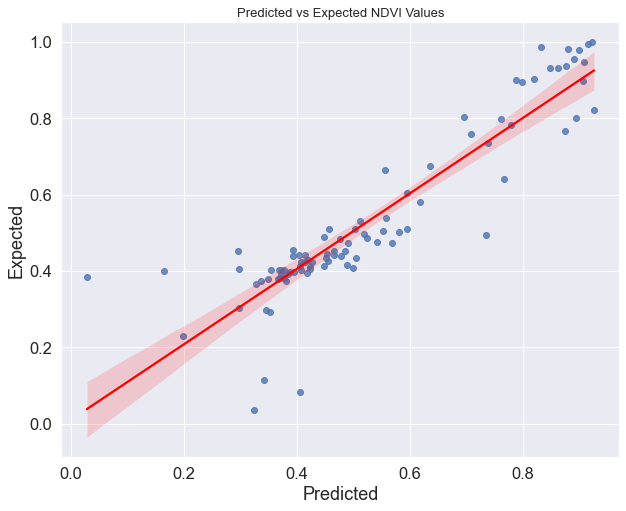

In [36]:
#passing results to dataframe
predicted_expected = pd.DataFrame({'Predicted':y_pred, 'Expected':y_test}) 


plt.figure(figsize=(10,8))
sns.regplot(x='Predicted', 
            y='Expected',
            fit_reg=True,
            data=predicted_expected,
            line_kws = {'color': 'red'})
plt.title('Predicted vs Expected NDVI Values', fontsize = 13)
plt.show()

In [37]:
# Get the coefficients of the model
coefs = model.coef_

# Create a dataframe of the coefficients
coef_df = pd.DataFrame({'feature': X.columns, 'coef': coefs})

# Sort the dataframe by absolute value of the coefficient
coef_df = coef_df.sort_values(by='coef', ascending=False)
coef_df["coef_abs"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values(by='coef_abs', ascending=False)

# Print the top 10 most impactful variables
print(coef_df.head(10))

             feature      coef  coef_abs
3          NDVI_1lag  0.660659  0.660659
0           TEMP_MIN  0.307680  0.307680
1               PRCP -0.037987  0.037987
2     HEATWAVE INDEX -0.033614  0.033614
7  DROUGHT INDEX_3.0 -0.026283  0.026283
4  DROUGHT INDEX_0.0  0.021841  0.021841
5  DROUGHT INDEX_1.0  0.019572  0.019572
6  DROUGHT INDEX_2.0 -0.019396  0.019396
9  DROUGHT INDEX_5.0  0.016785  0.016785
8  DROUGHT INDEX_4.0 -0.012519  0.012519


/Users/mattiacintioli/opt/anaconda3/envs/augurotech0/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


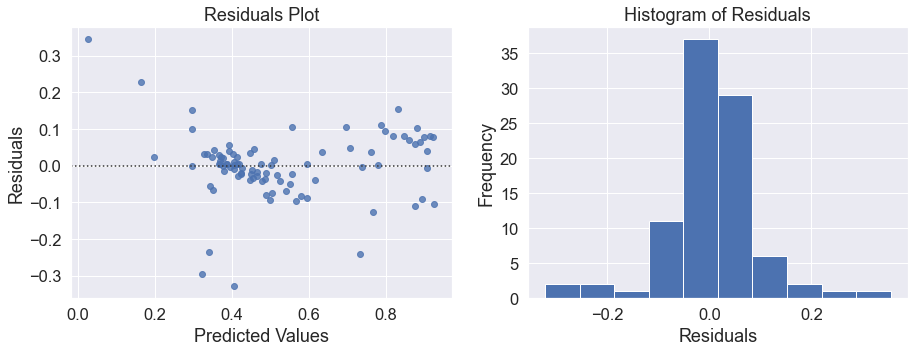

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

# calculate the residuals
residuals = y_test - y_pred

# plot the residuals
sns.residplot(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.subplot(1, 2, 2)

# Histogram of Residuals
plt.hist(residuals, bins=10)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.show()

Residuals look good

### One model for each parcel

In [39]:
def get_scores(parcel):    
    # Split the data into independent variables (X) and the target variable (y)
    X_0 = parcel[['RED', 'NIR', 'TEMP_MIN', 'PRCP', 'HEATWAVE INDEX', 'NDWI']]
    X_0 = parcel[['TEMP_MIN', 'PRCP', 'HEATWAVE INDEX', 'NDVI_1lag']]
    X_1 = parcel.iloc[:,17:-1] #drought dummy variables
    X = X_0.join(X_1)
    
    y = parcel['NDVI']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = X[:-92], X[-92:], y[:-92], y[-92:] #we are testing on last two years of data

    # Create an instance of the LinearRegression model
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the target variable for the testing data
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = model.score(X_test, y_test)
    
    return mse, rmse, r2

In [40]:
print('following parcels will be excluded because not enough data:')

#get all unique parcel ids
parcel_ids = result['parcel_id'].unique()

scores = [0,0,0]

#iterate trhough parcel ids
for parcel_id in parcel_ids:
    
    #extract parcel dataframe from id
    parcel = extract_parcel(parcel_id)
    
    
    if parcel.shape[0] == 46*19: #this condition ensures that we have at least 19 years of data, so 2 years for testing and the rest for training
        
        #do linear regression and obtain scores on testing set
        new_score = get_scores(parcel)

        #stack the scores
        scores = np.vstack((scores,new_score))
    else:
        print(parcel_id)
        
scores = scores[1:] #remove the first row of zeroes


following parcels will be excluded because not enough data:
27111
17131
31015
17159
27105
17171
17049
27095
27081
31105
27139
19113
31185
17165
17129
18133
27087
31149
31065
27093
17005
31121
27161
27149
31175
19155
27019
31059
31161
17181
17101
18023
17039
17041
19173
31035
17029
18033
27089
17055
27131
27009
19095
18067
27119
27153
31125
17001
31057
31009
31043
27035
27147
18073
27141
18107
17025
19117
31045
17189
31051
27129
19103
17109
19093
18083
31079
27101
19007
27115
18097
17047
31011
17135
18017
27051
17149
18153
31155
18147
17099
27045
27091
19183
17161
27085
27033
27079
31089
17151
17069
18101
19063
17145
18115
17127
31165
17185
17045
27059
17079
31099
17091
18077
27001
31041
19057
27145
27151
18053
27015
18143
17061
31081
27029
18093
31069
17075
31095
31033
19175
17157
18075
31073
17093
19099
19149
19071
17031
19185
17037
19105
18051
18045
18181
19111
17023
18039
27125
31097
17077
31153
19001
18085
27043
18005
27103
17067
31087
27047
31007
19079
27053
31157
18069
18151
2711

In [41]:
scores.shape

(180, 3)

In [42]:
#returning r2 values
scores[:,2]
#note that there are two parcels that have negative r2 (31105, 17151)

#print(scores[20])
#print(scores[145])
#print(parcel_ids[20])
#print(parcel_ids[145])

array([0.91423441, 0.82754148, 0.93466385, 0.92091951, 0.91388751,
       0.87991548, 0.91451266, 0.74896314, 0.89868525, 0.93214458,
       0.85195284, 0.8540715 , 0.91523742, 0.8577184 , 0.92580275,
       0.89835185, 0.92973124, 0.92221308, 0.94388524, 0.85510328,
       0.87884668, 0.69795415, 0.92003332, 0.90815253, 0.93055156,
       0.90907752, 0.91714094, 0.92823743, 0.9119058 , 0.91833694,
       0.91262794, 0.91021757, 0.93147893, 0.91618938, 0.92931661,
       0.9203856 , 0.70016934, 0.88253902, 0.94046599, 0.88445362,
       0.86909432, 0.89276501, 0.84904894, 0.86096518, 0.93002029,
       0.89143995, 0.89528533, 0.92878276, 0.92653438, 0.89238717,
       0.9425606 , 0.89488097, 0.88880316, 0.92664953, 0.93356837,
       0.91602327, 0.9022414 , 0.92918635, 0.92952242, 0.87810345,
       0.87767019, 0.80550539, 0.83341833, 0.78737358, 0.92349421,
       0.92963172, 0.9013229 , 0.92496657, 0.92741347, 0.93921927,
       0.86263966, 0.93273391, 0.93771927, 0.93400146, 0.91126

In [43]:
averages = scores.mean(axis=0)
print('MSE:', round(averages[0],3))
print('RMSE:', round(averages[1],3))
print('R2:', round(averages[2],3))

MSE: 0.007
RMSE: 0.085
R2: 0.898


### (NEW) One model for all data

In new we use only TEMP_MIN, PRCP, and NDVI_1lag as features

In [44]:
X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()

for parcel_id in parcel_ids:
    
    #extract parcel dataframe from id
    parcel = extract_parcel(parcel_id)
    
    
    if parcel.shape[0] == 46*19: #this condition ensures that we have at least 19 years of data, so 2 years for testing and the rest for training
        X_0 = parcel[['RED', 'NIR', 'TEMP_MIN', 'PRCP', 'HEATWAVE INDEX', 'NDWI']]
        X_0 = parcel[['TEMP_MIN', 'PRCP', 'HEATWAVE INDEX', 'NDVI_1lag']]
        X_0 = parcel[['TEMP_MIN', 'PRCP', 'NDVI_1lag']] #NEWWWW
        X_1 = parcel.iloc[:,17:-1] #drought dummy variables
        X = X_0.join(X_1)
        X = X_0 #NEWWWW

        y = parcel['NDVI']

        # Split the data into training and testing sets
        X_train, X_test = X_train.append(X[:-92]), X_test.append(X[-92:])
        y_train, y_test = y_train.append(y[:-92]), y_test.append(y[-92:]) #we are testing on last two years of data

X_train, X_test = X_train.fillna(0), X_test.fillna(0)

/var/folders/qv/b02y1c5s02bg1mclhpq0x87w0000gn/T/ipykernel_45933/717429743.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()


In [45]:
# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = model.predict(X_test)

# Print the coefficients of the model
print('model coefficients', model.coef_)

# Print the intercept of the model
print('model intercept', model.intercept_)

# The mean squared error
print("MSE - Test: %.3f" % mean_squared_error(y_test, y_pred))
# The Root mean squared error
print("RMSE - Test: %.4f" % mean_squared_error(y_test, y_pred, squared=False))
# Explained variance score: 1 is perfect prediction
print('R2 - Test: %.3f' % model.score(X_test, y_test))

model coefficients [ 0.33720971 -0.01638556  0.71286011]
model intercept -0.06656838431482232
MSE - Test: 0.008
RMSE - Test: 0.0871
R2 - Test: 0.902


In [46]:
# Get the coefficients of the model
coefs = model.coef_

# Create a dataframe of the coefficients
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': coefs})

# Sort the dataframe by absolute value of the coefficient
coef_df = coef_df.sort_values(by='coef', ascending=False)
coef_df["coef_abs"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values(by='coef_abs', ascending=False)

# Print the top 10 most impactful variables
print(coef_df.head(10))

     feature      coef  coef_abs
2  NDVI_1lag  0.712860  0.712860
0   TEMP_MIN  0.337210  0.337210
1       PRCP -0.016386  0.016386


/Users/mattiacintioli/opt/anaconda3/envs/augurotech0/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


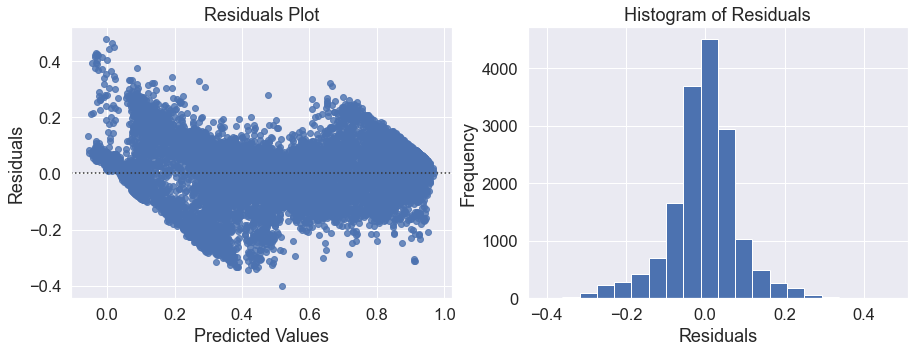

In [47]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

# calculate the residuals
residuals = y_test - y_pred

# plot the residuals
sns.residplot(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')


plt.subplot(1, 2, 2)

plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.show()

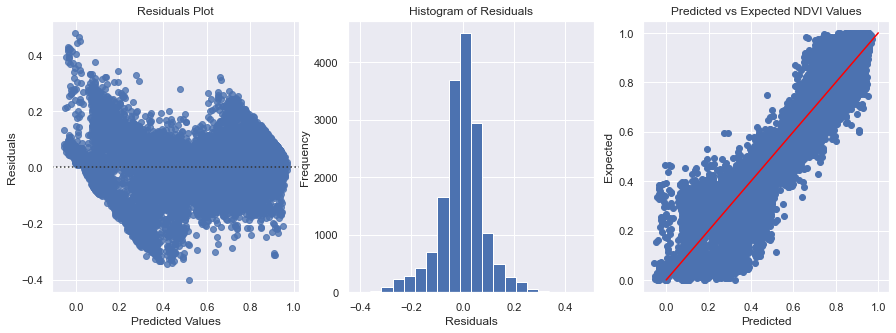

In [48]:
sns.set_theme(font_scale=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

# calculate the residuals
residuals = y_test - y_pred

# plot the residuals
sns.residplot(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')


plt.subplot(1, 3, 2)

plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')



plt.subplot(1, 3, 3)

predicted_expected = pd.DataFrame({'Predicted':y_pred, 'Expected':y_test}) 

plt.plot(y_pred, y_test, 'o')
line = np.linspace(0, 1, 2)
plt.plot(line, line, color='red')

plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.title('Predicted vs Expected NDVI Values')


plt.show()

From the histogram the errors look normal, but from the residuals plot there seems to be some variability in the errors (heteroskedasticity).

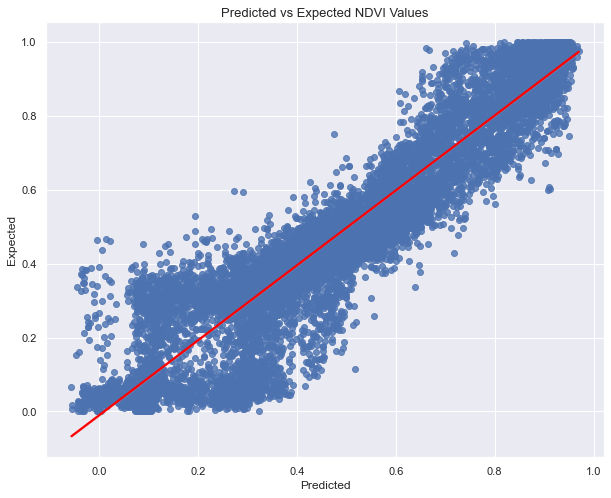

In [49]:
#passing results to dataframe
predicted_expected = pd.DataFrame({'Predicted':y_pred, 'Expected':y_test}) 


plt.figure(figsize=(10,8))
sns.regplot(x='Predicted', 
            y='Expected',
            fit_reg=True,
            data=predicted_expected,
            line_kws = {'color': 'red'})
plt.title('Predicted vs Expected NDVI Values', fontsize = 13)
plt.show()

## Modelling Part 2: Time Series

In [425]:
parcel = extract_parcel(17193)
parcel.shape
#874/46 = 19
#We have 19 years of data ranging from 2003 to 2021

(874, 24)

In [426]:
series_df = parcel
series_df["Date"]=series_df.index.values
series_df = series_df[["Date","NDVI"]]
series_df.head()

,Date,NDVI
date,,
0,0,0.435622
1,1,0.415955
2,2,0.297842
3,3,0.236737
4,4,0.394078


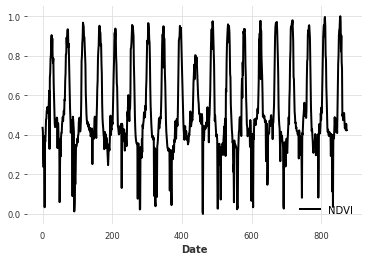

In [427]:
from darts import TimeSeries
#create TimeSeries object
series = TimeSeries.from_dataframe(series_df, time_col='Date')
series.plot()

In [428]:
from darts.utils.statistics import check_seasonality

#check for yearly seasonality (m = 46)
is_yearly_seasonal, yearly_period = check_seasonality(series, m=46, max_lag=400, alpha=0.05)

#check for quarterly seasonality (m = 46/4 = 11.5 ≈ 12)
is_quarterly_seasonal, quarterly_period = check_seasonality(series, m=12, max_lag=400, alpha=0.05)

print(f'Yearly seasonality: {is_yearly_seasonal} - period = {yearly_period}')
print(f'Quarterly seasonality: {is_quarterly_seasonal} - period = {quarterly_period}')

Yearly seasonality: True - period = 46
Quarterly seasonality: False - period = 12


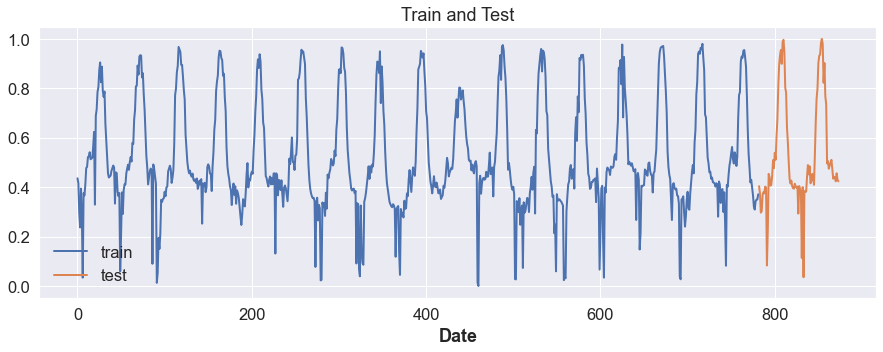

In [514]:
#take last two years as test set
sns.set_theme(font_scale=1.5)

plt.figure(figsize=(15, 5))

train, test = series[:-92], series[-92:]

train.plot(label='train')
test.plot(label='test')
plt.title('Train and Test')
plt.show()

Take also series for TEMP_MIN and PRCP

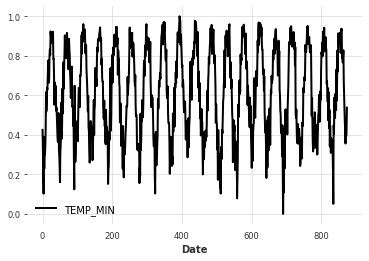

In [144]:
#Creating TEMP_MIN dataframe
series_df = parcel
series_df["Date"]=series_df.index.values
series_df = series_df[["Date","TEMP_MIN"]]
series_df.head()

#create TEMP_MIN TimeSeries object
series_TEMP_MIN = TimeSeries.from_dataframe(series_df, time_col='Date')
series_TEMP_MIN.plot()

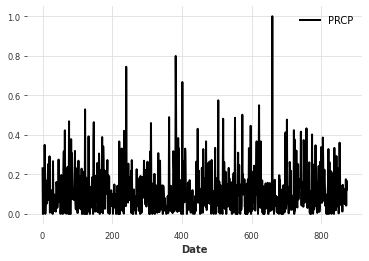

In [143]:
#Creating PRCP dataframe
series_df = parcel
series_df["Date"]=series_df.index.values
series_df = series_df[["Date","PRCP"]]
series_df.head()

#create TEMP_MIN TimeSeries object
series_PRCP = TimeSeries.from_dataframe(series_df, time_col='Date')
series_PRCP.plot()

Now we are ready to start with the modelling

### SNAIVE (Seasonal Naive)

We start with a simple model as baseline

In [524]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=46)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(92)

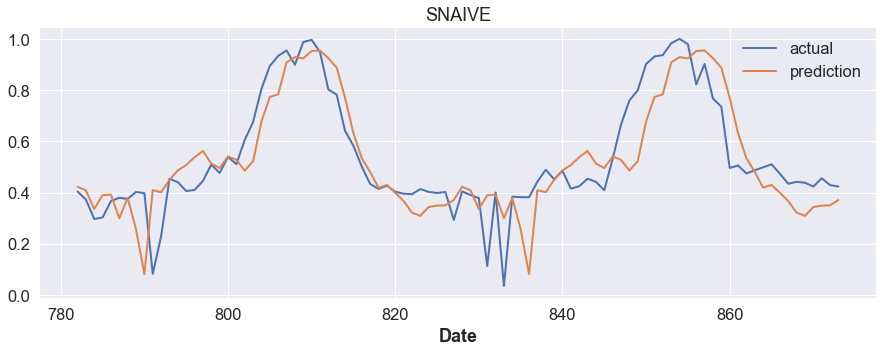

In [525]:
plt.figure(figsize=(15, 5))
test.plot(label='actual')
pred_naive.plot(label='prediction')

sns.set_theme(font_scale=1.5)

plt.title('SNAIVE')
plt.show()

In [48]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

0.09141167509855667


In [53]:
from darts.metrics import rmse

naive_rmse = rmse(test, pred_naive)

print(naive_rmse)

0.1203939653944331


### SNAIVE +  DRIFT

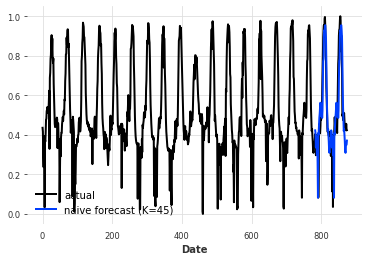

In [93]:
seasonal_model = NaiveSeasonal(K=46)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(92)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=46)")

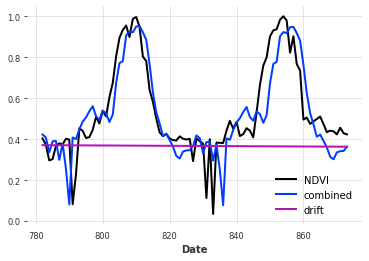

In [96]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(92)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

test.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [98]:
naive_seasoanl_rmse = rmse(test, combined_forecast)

print(naive_seasoanl_rmse)

0.1210815021712672


### NBEATS

In [58]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [128]:
#Initialize the model
nbeats = NBEATSModel(
    input_chunk_length=92, 
    output_chunk_length=46,
    generic_architecture=True,
    random_state=42)

#Fit the model
nbeats.fit(
    scaled_train,
    epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.7 M 
---------------------------------------------------
6.7 M     Trainable params
1.8 K     Non-trainable params
6.7 M     Total params
53.900    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [129]:
#Create forecasts
scaled_pred_nbeats = nbeats.predict(n=92)

#Reverse transformation (scaler)
pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [130]:
mae_nbeats = mae(test, pred_nbeats)

rmse_nbeats = rmse(test, pred_nbeats)

print('mae:',mae_nbeats)
print('rmse',rmse_nbeats)

mae: 0.07646164083915026
rmse 0.09940320962531699


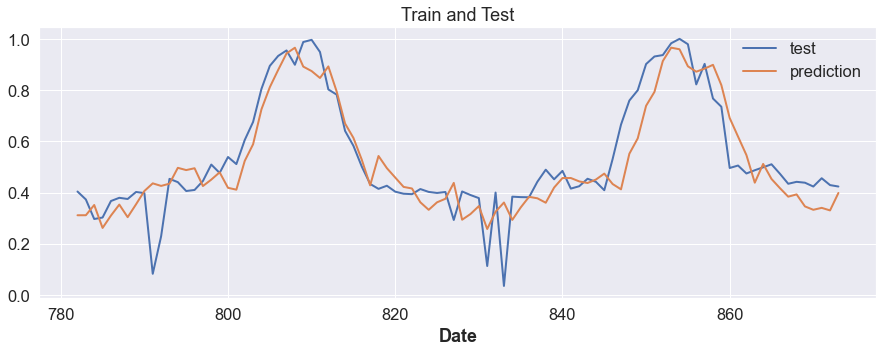

In [519]:
plt.figure(figsize=(15, 5))
test.plot(label='test')
pred_nbeats.plot(label='prediction')
sns.set_theme(font_scale=1.5)

plt.title('Train and Test')


plt.show()


### Trying covariates

In [194]:
from darts.models import RNNModel

model_futcov = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=50,
    random_state=0,
    training_length=92,
    input_chunk_length=92,
    force_reset=True,
)

model_futcov.fit(
    series=train,
    future_covariates=series_TEMP_MIN,
    verbose=True,
);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.9 K 
4 | V             | Linear           | 21    
---------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

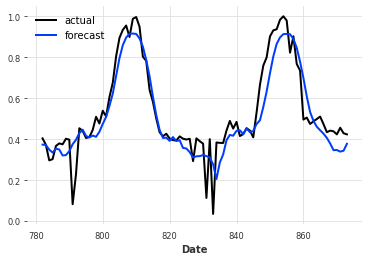

In [195]:
pred_cov = model_futcov.predict(
    n=92, series=train, future_covariates=series_TEMP_MIN
)

test.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend();

In [196]:
print('rmse',rmse(test, pred_cov))

rmse 0.08665093775467594


### Covariate regression

### ETS

In [102]:
model = ExponentialSmoothing(seasonal_periods=46)
model.fit(train)
prediction = model.predict(len(test), num_samples=1000)

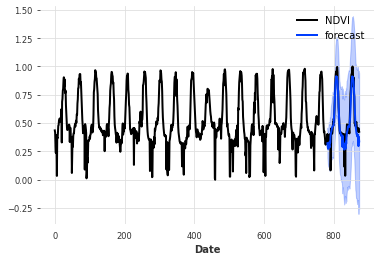

In [103]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

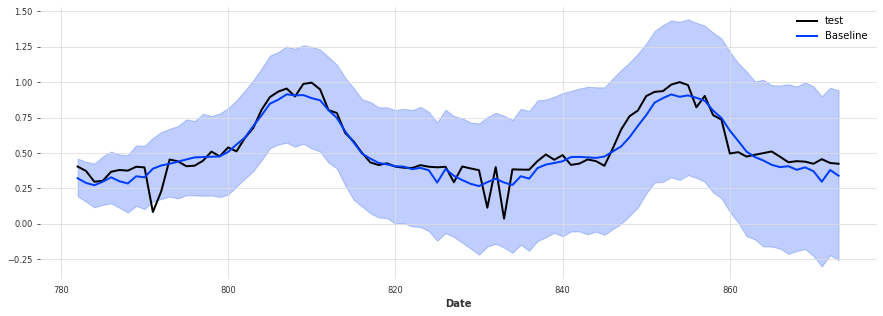

In [127]:
plt.figure(figsize=(15, 5))
test.plot(label='test')
prediction.plot(label='Baseline')
plt.show()

In [105]:
print('mae:',mae(test, prediction))
print('rmse',rmse(test, prediction))

mae: 0.06095537888419335
rmse 0.08097635280912721


### LightGBMModel and XGBModel

In [529]:
from darts.models import LightGBMModel


model = LightGBMModel(lags=30,
                      output_chunk_length=8,
                              likelihood="quantile",
                              quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
model.fit(train)
prediction = model.predict(len(test))


print('mae:',mae(test, prediction))
print('rmse',rmse(test, prediction))

mae: 0.05330735249810381
rmse 0.07700475427071107


In [557]:
prediction_numpy = prediction.all_values()
type(prediction_numpy)

numpy.ndarray

In [558]:
prediction_numpy

array([[[0.35331378]],

       [[0.30122585]],

       [[0.28225709]],

       [[0.19517993]],

       [[0.1834667 ]],

       [[0.26483882]],

       [[0.29639197]],

       [[0.29409632]],

       [[0.32155868]],

       [[0.34875151]],

       [[0.36454319]],

       [[0.40538228]],

       [[0.41970808]],

       [[0.44313608]],

       [[0.44097099]],

       [[0.46078919]],

       [[0.47031705]],

       [[0.47144014]],

       [[0.47390603]],

       [[0.52042436]],

       [[0.62391148]],

       [[0.67160228]],

       [[0.82136997]],

       [[0.86474403]],

       [[0.91708609]],

       [[0.91765354]],

       [[0.94066517]],

       [[0.93503525]],

       [[0.87230575]],

       [[0.88013889]],

       [[0.83248263]],

       [[0.76901685]],

       [[0.69067036]],

       [[0.59264327]],

       [[0.48903415]],

       [[0.51051431]],

       [[0.43315856]],

       [[0.42200749]],

       [[0.4224256 ]],

       [[0.41538489]],

       [[0.41674739]],

       [[0.41737

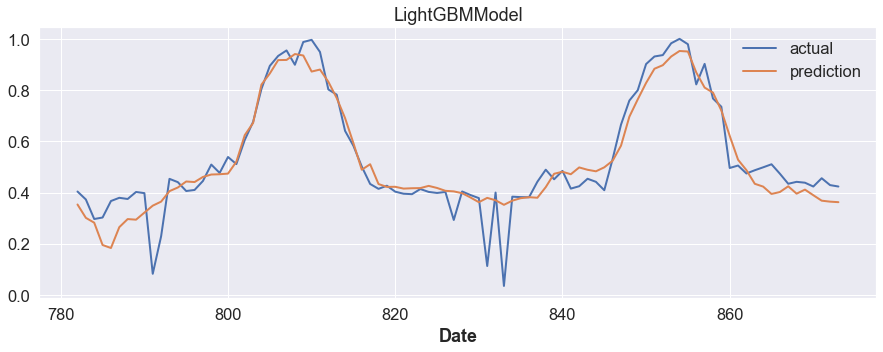

In [523]:
plt.figure(figsize=(15, 5))
test.plot(label='actual')
prediction.plot(label='prediction')
sns.set_theme(font_scale=1.5)

plt.title('LightGBMModel')

plt.show()

In [317]:
from darts.models import XGBModel


model = XGBModel(lags=20,
  #                            likelihood="quantile",
  #                            quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95],
                 output_chunk_length=8
                )
model.fit(train)
prediction = model.predict(len(test))


print('mae:',mae(test, prediction))
print('rmse',rmse(test, prediction))

mae: 0.09146266213839191
rmse 0.11821244368960777


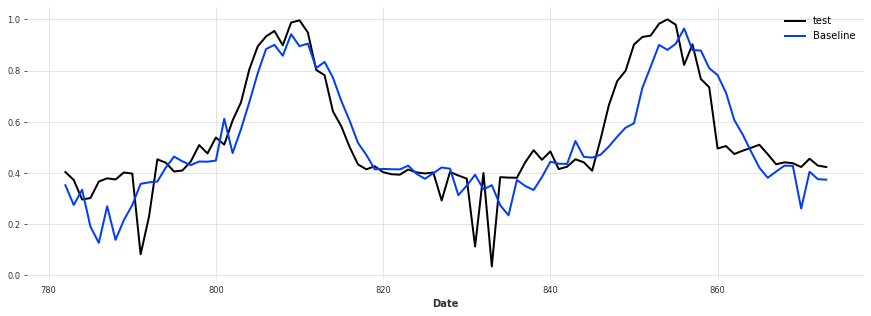

In [318]:
plt.figure(figsize=(15, 5))
test.plot(label='test')
prediction.plot(label='Baseline')
plt.show()

## Best model on all data

In [418]:
def get_rmse(parcel):
    series_df = parcel
    series_df["Date"]=series_df.index.values
    series_df = series_df[["Date","NDVI"]]
    series = TimeSeries.from_dataframe(series_df, time_col='Date')
    train, test = series[:-92], series[-92:]
    
    model = ExponentialSmoothing(seasonal_periods=46)
    
    model = LightGBMModel(lags=30,
                      output_chunk_length=8,
                              likelihood="quantile",
                              quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
    
    model.fit(train)
    prediction = model.predict(len(test), num_samples=1000)
    return rmse(test, prediction)

In [419]:
print('following parcels will be excluded because not enough data:')

#get all unique parcel ids
parcel_ids = result['parcel_id'].unique()

scores = [0]

#iterate trhough parcel ids
for parcel_id in parcel_ids:
    
    #extract parcel dataframe from id
    parcel = extract_parcel(parcel_id)
    
    
    if parcel.shape[0] == 46*19: #this condition ensures that we have at least 19 years of data, so 2 years for testing and the rest for training
        
        #do linear regression and obtain scores on testing set
        new_score = get_rmse(parcel)

        #stack the scores
        scores = np.vstack((scores,new_score))
    else:
        print(parcel_id)
        
scores = scores[1:] #remove the first row of zeroes

#0.0846


following parcels will be excluded because not enough data:
27111
17131
31015
17159
27105
17171
17049
27095
27081
31105
27139
19113
31185
17165
17129
18133
27087
31149
31065
27093
17005
31121
27161
27149
31175
19155
27019
31059
31161
17181
17101
18023
17039
17041
19173
31035
17029
18033
27089
17055
27131
27009
19095
18067
27119
27153
31125
17001
31057
31009
31043
27035
27147
18073
27141
18107
17025
19117
31045
17189
31051
27129
19103
17109
19093
18083
31079
27101
19007
27115
18097
17047
31011
17135
18017
27051
17149
18153
31155
18147
17099
27045
27091
19183
17161
27085
27033
27079
31089
17151
17069
18101
19063
17145
18115
17127
31165
17185
17045
27059
17079
31099
17091
18077
27001
31041
19057
27145
27151
18053
27015
18143
17061
31081
27029
18093
31069
17075
31095
31033
19175
17157
18075
31073
17093
19099
19149
19071
17031
19185
17037
19105
18051
18045
18181
19111
17023
18039
27125
31097
17077
31153
19001
18085
27043
18005
27103
17067
31087
27047
31007
19079
27053
31157
18069
18151
2711

In [430]:
scores_save = scores

In [421]:
scores.mean()

0.08464383075106859

### Trying baseline snaive for all parcels

In [431]:
def get_rmse(parcel):
    series_df = parcel
    series_df["Date"]=series_df.index.values
    series_df = series_df[["Date","NDVI"]]
    series = TimeSeries.from_dataframe(series_df, time_col='Date')
    train, test = series[:-92], series[-92:]
    
    
    model = NaiveSeasonal(K=46)
 
    
    model.fit(train)
    prediction = model.predict(92)
    return rmse(test, prediction)

In [432]:
print('following parcels will be excluded because not enough data:')

#get all unique parcel ids
parcel_ids = result['parcel_id'].unique()

scores = [0]

#iterate trhough parcel ids
for parcel_id in parcel_ids:
    
    #extract parcel dataframe from id
    parcel = extract_parcel(parcel_id)
    
    
    if parcel.shape[0] == 46*19: #this condition ensures that we have at least 19 years of data, so 2 years for testing and the rest for training
        
        #do linear regression and obtain scores on testing set
        new_score = get_rmse(parcel)

        #stack the scores
        scores = np.vstack((scores,new_score))
    else:
        print(parcel_id)
        
scores = scores[1:] #remove the first row of zeroes

#0.0846
scores.mean()

following parcels will be excluded because not enough data:
27111
17131
31015
17159
27105
17171
17049
27095
27081
31105
27139
19113
31185
17165
17129
18133
27087
31149
31065
27093
17005
31121
27161
27149
31175
19155
27019
31059
31161
17181
17101
18023
17039
17041
19173
31035
17029
18033
27089
17055
27131
27009
19095
18067
27119
27153
31125
17001
31057
31009
31043
27035
27147
18073
27141
18107
17025
19117
31045
17189
31051
27129
19103
17109
19093
18083
31079
27101
19007
27115
18097
17047
31011
17135
18017
27051
17149
18153
31155
18147
17099
27045
27091
19183
17161
27085
27033
27079
31089
17151
17069
18101
19063
17145
18115
17127
31165
17185
17045
27059
17079
31099
17091
18077
27001
31041
19057
27145
27151
18053
27015
18143
17061
31081
27029
18093
31069
17075
31095
31033
19175
17157
18075
31073
17093
19099
19149
19071
17031
19185
17037
19105
18051
18045
18181
19111
17023
18039
27125
31097
17077
31153
19001
18085
27043
18005
27103
17067
31087
27047
31007
19079
27053
31157
18069
18151
2711

0.11942179626319746

baseline snaive has 0.12 rmse while lightGBM 0.085.